### Llamadas 911 desde el primer semestre del 2019 hasta el primer semestre del 2022

In [2]:
### Importar librerías
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, concatenate, Embedding, Dropout, BatchNormalization, Bidirectional
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import OneHotEncoder

In [17]:
### Combinación de múltiples archivos CSV en uno solo

# Ruta a la carpeta donde están los archivos CSV
ruta_archivos = './Datos/'

# Nombre del archivo combinado
archivo_combinado = './Datos/llamadas_911_combinado.csv'

# Verificar si el archivo combinado ya existe
if os.path.exists(archivo_combinado):
    print(f"El archivo '{archivo_combinado}' ya existe. No se realizará la combinación.")
else:
    # Especifica el patrón de los archivos CSV
    archivo_csv = glob.glob(ruta_archivos + 'llamadas_911_*.csv')

    # Lista para almacenar tamaños de cada archivo
    tamanos_individuales = {}

    # Leer cada archivo, manejar errores de codificación y contar filas
    dataframes = []
    for archivo in archivo_csv:
        nombre_archivo = archivo.split('/')[-1]
        try:
            df = pd.read_csv(archivo, encoding='ISO-8859-1')
        except UnicodeDecodeError:
            df = pd.read_csv(archivo, encoding='cp1252')
        dataframes.append(df)
        tamanos_individuales[nombre_archivo] = df.shape[0]

    # Combinar todos los DataFrames en uno solo
    df_combinado = pd.concat(dataframes, ignore_index=True)

    # Guardar el DataFrame combinado en un archivo CSV
    df_combinado.to_csv(archivo_combinado, index=False)

    # Calcular la suma de los tamaños individuales
    suma_tamanos_individuales = sum(tamanos_individuales.values())
    print(f"Se combinó un total de {suma_tamanos_individuales} filas en '{archivo_combinado}'.")

El archivo './Datos/llamadas_911_combinado.csv' ya existe. No se realizará la combinación.


In [3]:
### Primer análisis del DataFrame combinado

# Abrir el archivo CSV combinado
df_llamadas = pd.read_csv('./Datos/llamadas_911_combinado.csv')

In [86]:
# # Columnas del DataFrame
# print(df_llamadas.columns)

In [ ]:
# # Regresar los valores únicos de las columnas 'categoria_incidente_c4'
# categorias_incidente = df_llamadas['categoria_incidente_c4'].unique()
# print("\nCategorías de incidentes reportados:")
# print(categorias_incidente)


Categorías de incidentes reportados:
['Medicos' 'Denuncia' 'Danos' 'Servicios' 'Robo' 'Disturbio' 'Incendio'
 'Agresion' 'Danos por fenomeno natural o tercero'
 'Privacion de la libertad' 'Denuncia de hechos' 'Amenaza' 'Lesionado'
 'Derrame o fuga' 'Contra la salud' 'Administrativas'
 'Detencion ciudadana' 'Cadaver' 'Abandono' 'Explosion' 'Abandono '
 'Sismo' 'Accidente' 'Electorales' 'Intento de suicidio' nan
 'Persona extraviada en zona boscosa']


In [85]:
# # Regresar los valores únicos de las columnas 'codigo_cierre'
# categorias_incidente = df_llamadas['anio_creacion'].unique()
# print("\nCategorías de cierres:")
# print(categorias_incidente)

In [75]:
### Ajuste para remover diciembre 2020
df_llamadas = df_llamadas[~((df_llamadas['anio_creacion'] == 2020) & (df_llamadas['mes_creacion'] == 'Diciembre'))]

In [84]:
# # Asegúrate de que la columna de fecha esté en formato datetime
# df_llamadas['fecha_cierre'] = pd.to_datetime(df_llamadas['fecha_cierre'], errors='coerce')

# # Crear una columna de año-mes para el conteo
# df_llamadas['anio_mes'] = df_llamadas['fecha_cierre'].dt.to_period('M')

# # Contar llamadas por año-mes
# conteo_mensual = df_llamadas.groupby('anio_mes').size()

# # Rellenar meses faltantes con 0
# conteo_mensual = conteo_mensual.reindex(pd.period_range(start=df_llamadas['anio_mes'].min(),
#                                                         end=df_llamadas['anio_mes'].max(), freq='M'), fill_value=0)

# # Convertir a DataFrame para visualización
# conteo_mensual_df = conteo_mensual.reset_index()
# conteo_mensual_df.columns = ['Mes', 'Total_Llamadas']

# # Mostrar el DataFrame con el conteo mensual incluyendo meses con 0
# conteo_mensual_df

# # Graficar el conteo mensual de llamadas
# plt.figure(figsize=(12, 6))
# plt.plot(conteo_mensual_df['Mes'].astype(str), conteo_mensual_df['Total_Llamadas'], marker='o')
# plt.xticks(rotation=45)
# plt.xlabel('Mes')
# plt.ylabel('Total de Llamadas')
# plt.title('Total de Llamadas al 911 por Mes')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [83]:
# ### Verificar cantidad de NaNs en el DataFrame
# print("\nCantidad de valores nulos por columna:")
# print(df_llamadas.isnull().sum())

# # # Ver qué características tienen las filas donde 'categoria_incidente_c4' es nulo en contraste con el total de filas
# # print("\nFilas con 'categoria_incidente_c4' nulo:")
# # print(df_llamadas[df_llamadas['categoria_incidente_c4'].isnull()])

# # Contar cuántas filas tienen 'categoria_incidente_c4'
# conteo_categoria_incidente = df_llamadas['categoria_incidente_c4'].count()
# total_filas = df_llamadas.shape[0]
# print(f"\nPorcentaje de filas con 'categoria_incidente_c4' no nulo: {conteo_categoria_incidente / total_filas:.2%}")

# # Eliminar filas con 'categoria_incidente_c4' nulo
# df_llamadas = df_llamadas.dropna(subset=['categoria_incidente_c4'])


---
## Diseño del Modelo
### Entrada Geográfica (CNN):

- Convertir las coordenadas en cuadrículas para capturar patrones espaciales relacionados con los tipos de cierre (codigo_cierre). \
- La CNN detectará patrones de áreas geográficas con alta frecuencia de llamadas reales, falsas, etc.

### Entrada Temporal (LSTM):

- Usar datos como el día del año, la hora y otras características temporales para capturar estacionalidad y patrones temporales.
- La LSTM identificará tendencias en las llamadas relacionadas con temporadas o días específicos.

### Concatenación y Clasificación:

- Combinar las salidas de CNN y LSTM.
- Añadir una capa densa para predecir la probabilidad de cada clase de codigo_cierre.

### Procesamiento de datos

#### 1.1 Datos Espaciales
El modelo CNN espera una entrada en forma de matriz (10x10 en este caso). Sigue estos pasos para transformar las coordenadas en cuadrículas: \
Paso 1: Normalizar las coordenadas (latitud, longitud) para que estén en un rango uniforme. \
Paso 2: Dividir las coordenadas en una cuadrícula (e.g., 10x10). \
Paso 3: Crear una matriz de frecuencia para cada cuadrícula (representando la intensidad de llamadas en cada región).

#### 1.2 Datos Temporales (fecha_creacion, hora_creacion)
El modelo LSTM espera datos en formato de secuencia temporal. Aquí transformaremos los datos:

- Paso 1: Extraer características temporales relevantes como el día de la semana, hora, mes, etc.
- Paso 2: Agrupar llamadas en secuencias de tiempo (e.g., 24 horas).

#### 1.3 Categoría del Incidente (categoria_incidente_c4)
La columna categoria_incidente_c4 necesita ser convertida en un índice o embedding:

- Paso 1: Convertir las categorías en índices únicos.
- Paso 2: Pasar estos índices al modelo como entrada para embeddings.

In [78]:
# import matplotlib.pyplot as plt

# # Contar la cantidad de ocurrencias de cada clase en 'codigo_cierre'
# clase_counts = df_llamadas['codigo_cierre'].value_counts()

# # Mostrar la distribución de las clases
# print(clase_counts)

# # Visualizar el balance de las clases en un gráfico de barras
# plt.figure(figsize=(10, 6))
# clase_counts.plot(kind='bar')
# plt.xlabel('Clase de Cierre')
# plt.ylabel('Número de Llamadas')
# plt.title('Distribución de las Clases en "codigo_cierre"')
# plt.show()


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, concatenate, Embedding, Dropout, BatchNormalization, Bidirectional
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import OneHotEncoder

# ---- 1. Procesar Datos Espaciales (latitud, longitud) ----

# Eliminar columnas no necesarias para reducir uso de memoria
columnas_utilizadas = ['latitud', 'longitud', 'fecha_creacion', 'hora_creacion', 'categoria_incidente_c4', 'codigo_cierre']
df_llamadas = df_llamadas[columnas_utilizadas]

# Normalizar coordenadas
df_llamadas['lat_norm'] = (df_llamadas['latitud'] - df_llamadas['latitud'].min()) / (df_llamadas['latitud'].max() - df_llamadas['latitud'].min())
df_llamadas['lon_norm'] = (df_llamadas['longitud'] - df_llamadas['longitud'].min()) / (df_llamadas['longitud'].max() - df_llamadas['longitud'].min())

# Crear cuadrículas
grid_size = 10
df_llamadas['lat_bin'] = (df_llamadas['lat_norm'] * (grid_size - 1)).astype(int)
df_llamadas['lon_bin'] = (df_llamadas['lon_norm'] * (grid_size - 1)).astype(int)

# Crear matriz para CNN
X_cnn = np.zeros((len(df_llamadas), grid_size, grid_size, 1), dtype=np.float32)
for idx, row in df_llamadas.iterrows():
    if idx < len(X_cnn) and 0 <= row['lat_bin'] < grid_size and 0 <= row['lon_bin'] < grid_size:
        X_cnn[idx, row['lat_bin'], row['lon_bin'], 0] = 1

# ---- 2. Procesar Datos Temporales (fecha_creacion, hora_creacion) ----

# Definir la longitud de la secuencia
sequence_length = 24

# Convertir fecha a datetime, forzando la conversión y filtrando fechas inválidas
df_llamadas['fecha_creacion'] = pd.to_datetime(df_llamadas['fecha_creacion'], errors='coerce')
df_llamadas = df_llamadas[df_llamadas['fecha_creacion'].notna()]

# Crear características temporales
df_llamadas['dia_semana'] = df_llamadas['fecha_creacion'].dt.dayofweek  # 0: Lunes, 6: Domingo

# Extraer la hora de 'hora_creacion' en formato HH:MM:SS
df_llamadas['hora'] = df_llamadas['hora_creacion'].str.split(':').str[0].astype(int)
df_llamadas['mes'] = df_llamadas['fecha_creacion'].dt.month

# Normalizar características
df_llamadas['hora_norm'] = df_llamadas['hora'] / 23.0
df_llamadas['dia_semana_norm'] = df_llamadas['dia_semana'] / 6.0
df_llamadas['mes_norm'] = df_llamadas['mes'] / 12.0

# Crear secuencias temporales utilizando un enfoque más eficiente, agregando latitud y longitud normalizadas
data_temporal = df_llamadas[['hora_norm', 'dia_semana_norm', 'mes_norm', 'lat_norm', 'lon_norm']].values.astype(np.float32)
X_lstm = [data_temporal[i:i+sequence_length] for i in range(0, len(data_temporal) - sequence_length, sequence_length)]
X_lstm = np.array(X_lstm)

# ---- 3. Procesar Categorías (categoria_incidente_c4) ----

# Crear mapa de categorías
categoria_map = {cat: idx for idx, cat in enumerate(df_llamadas['categoria_incidente_c4'].dropna().unique())}
df_llamadas['categoria_idx'] = df_llamadas['categoria_incidente_c4'].map(categoria_map).fillna(0).astype(int)

# Preparar entrada para embeddings
X_cat = df_llamadas['categoria_idx'].values[:len(X_lstm)]

# ---- 4. Procesar Etiquetas (codigo_cierre) ----

# Procesar etiquetas multiclase (A, I, N, D, F)
categoria_etiqueta_map = {'A': 0, 'I': 1, 'N': 2, 'D': 3, 'F': 4}
df_llamadas['codigo_cierre_idx'] = df_llamadas['codigo_cierre'].map(categoria_etiqueta_map).fillna(0).astype(int)
y = tf.keras.utils.to_categorical(df_llamadas['codigo_cierre_idx'].values[:len(X_lstm)], num_classes=5)

# ---- 5. Ajustar Dimensiones y Entrenamiento del Modelo ----

# Ajustar tamaño de X_cnn para que coincida con X_lstm
X_cnn = X_cnn[:len(X_lstm)]

# ---- 6. Arquitectura del Modelo ----

# Entrada geográfica (CNN)
input_cnn = Input(shape=(10, 10, 1), name='Input_CNN')
cnn = Conv2D(8, (3, 3), activation='relu', padding='same')(input_cnn)
cnn = MaxPooling2D((2, 2))(cnn)
cnn = Flatten()(cnn)
cnn_output = cnn


# Entrada temporal (LSTM)
input_lstm = Input(shape=(24, 5), name='Input_LSTM')
lstm = LSTM(16, activation='tanh', return_sequences=False)(input_lstm)
lstm_output = lstm



# Embeddings para `categoria_incidente_c4`
input_cat = Input(shape=(1,), name='Input_Category')
embedding = Embedding(input_dim=len(categoria_map)+1, output_dim=8)(input_cat)
embedding = Flatten()(embedding)

# Concatenación
combined = concatenate([cnn_output, lstm_output, embedding], name='Concatenate')
dense = Dense(16, activation='relu')(combined)

dense = Dropout(0.3)(dense)
output = Dense(5, activation='softmax', name='Output')(dense)  # Salida multiclase (A, I, N, D, F)

# Definición del modelo
model = Model(inputs=[input_cnn, input_lstm, input_cat], outputs=output, name='Spatial_Temporal_Model')

# Compilación
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

# ---- 7. Entrenamiento del Modelo ----

from sklearn.utils.class_weight import compute_class_weight


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
history = model.fit(
    [X_cnn, X_lstm, X_cat], y,
    batch_size=32, epochs=10, validation_split=0.2, callbacks=[reduce_lr]
)

Model: "Spatial_Temporal_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_CNN (InputLayer)         [(None, 10, 10, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 10, 10, 8)    80          ['Input_CNN[0][0]']              
                                                                                                  
 Input_Category (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 5, 5, 8)      0           ['conv2d[0][0]']                 
                                                                             

In [11]:
from graphviz import Digraph

# Crear un diagrama orientado de manera vertical con fondo transparente
dot = Digraph('Model_Architecture', format='png')

# Definir las características del gráfico
dot.attr(bgcolor='transparent', rankdir='TB', color='#DAFFFB', fontcolor='#DAFFFB')  # Fondo transparente y orientación vertical (top to bottom)

# Añadir nodos para cada capa del modelo
dot.node('Input_CNN', 'Input CNN (10x10x1)', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('Conv2D', 'Conv2D (16 filtros)', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('MaxPooling', 'MaxPooling (5x5x16)', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('Flatten_CNN', 'Flatten (400)', color='#DAFFFB', fontcolor='#DAFFFB')

dot.node('Input_LSTM', 'Input LSTM (24x5)', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('LSTM', 'LSTM (32 unidades)', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('BatchNorm_LSTM', 'Batch Normalization (LSTM)', color='#DAFFFB', fontcolor='#DAFFFB')

dot.node('Input_Category', 'Input Category (1)', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('Embedding', 'Embedding (8 dim)', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('Flatten_Embedding', 'Flatten (8)', color='#DAFFFB', fontcolor='#DAFFFB')

dot.node('Concatenation', 'Concatenation', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('Dense', 'Dense Layer (32 unidades)', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('Dropout', 'Dropout (30%)', color='#DAFFFB', fontcolor='#DAFFFB')
dot.node('Output', 'Output Layer (5 clases)', color='#DAFFFB', fontcolor='#DAFFFB')

# Añadir las relaciones entre las capas como tuplas y establecer color para los bordes
edges = [
    ('Input_CNN', 'Conv2D'),
    ('Conv2D', 'MaxPooling'),
    ('MaxPooling', 'Flatten_CNN'),
    ('Input_LSTM', 'LSTM'),
    ('LSTM', 'BatchNorm_LSTM'),
    ('Input_Category', 'Embedding'),
    ('Embedding', 'Flatten_Embedding'),
    ('Flatten_CNN', 'Concatenation'),
    ('BatchNorm_LSTM', 'Concatenation'),
    ('Flatten_Embedding', 'Concatenation'),
    ('Concatenation', 'Dense'),
    ('Dense', 'Dropout'),
    ('Dropout', 'Output')
]

# Añadir los bordes al gráfico con el color deseado
for edge in edges:
    dot.edge(*edge, color='#DAFFFB')

# Guardar el diagrama
dot.render('model_architecture', view=True)

'model_architecture.png'

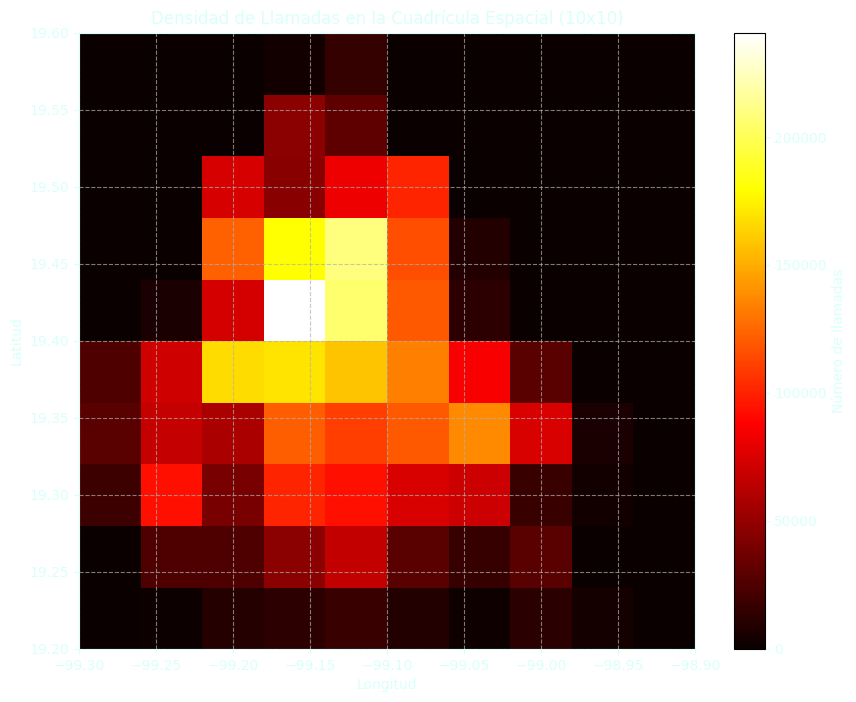

In [13]:
# Graficar la densidad de llamadas en la cuadrícula
plt.figure(figsize=(10, 8))
im = plt.imshow(density_matrix, cmap='hot', extent=[-99.3, -98.9, 19.2, 19.6], origin='lower')

# Ajustar color del texto, fondo, y cambiar la escala de colores
plt.title('Densidad de Llamadas en la Cuadrícula Espacial (10x10)', color='#DAFFFB')
plt.xlabel('Longitud', color='#DAFFFB')
plt.ylabel('Latitud', color='#DAFFFB')

# Cambiar el color de los ejes a #DAFFFB
plt.gca().spines['top'].set_color('#DAFFFB')
plt.gca().spines['bottom'].set_color('#DAFFFB')
plt.gca().spines['left'].set_color('#DAFFFB')
plt.gca().spines['right'].set_color('#DAFFFB')

# Cambiar el color de los ticks a #DAFFFB
plt.gca().tick_params(axis='x', colors='#DAFFFB')
plt.gca().tick_params(axis='y', colors='#DAFFFB')

# Añadir la barra de color y cambiar el color del texto
cbar = plt.colorbar(im)
cbar.set_label('Número de llamadas', color='#DAFFFB')
cbar.ax.yaxis.set_tick_params(color='#DAFFFB')  # Cambiar el color de los ticks en la barra de color
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#DAFFFB')  # Cambiar el color de las etiquetas de los ticks

plt.grid(True, linestyle='--', alpha=0.7)

# Guardar como PNG con fondo transparente
plt.savefig('densidad_llamadas.png', transparent=True)
plt.show()

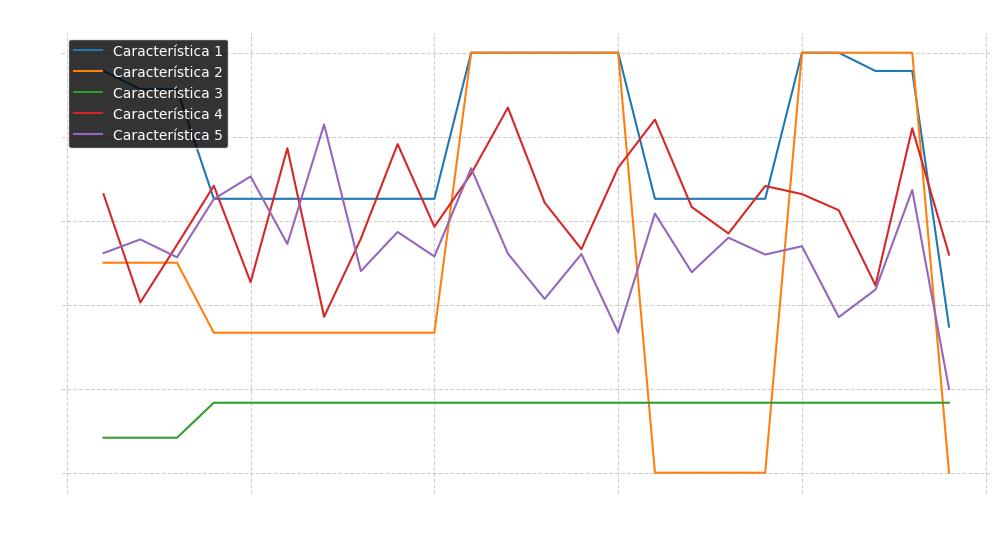

In [23]:
import matplotlib.pyplot as plt

# Secuencia de ejemplo
indice_ejemplo = 10
secuencia_ejemplo = X_lstm[indice_ejemplo]

# Crear una figura para visualizar la secuencia temporal
plt.figure(figsize=(12, 6))
for i in range(secuencia_ejemplo.shape[1]):
    plt.plot(range(1, len(secuencia_ejemplo) + 1), secuencia_ejemplo[:, i], label=f'Característica {i + 1}')

plt.xlabel('Paso de Tiempo', color='white')
plt.ylabel('Valor Normalizado', color='white')
plt.title('Ejemplo de Secuencias Temporales Utilizadas en el LSTM', color='white')
plt.legend(facecolor='black', edgecolor='white', labelcolor='white')
plt.grid(True, linestyle='--', alpha=0.6)

# Cambiar el color de los ejes y ticks a blanco
plt.gca().spines['top'].set_color('white')
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['left'].set_color('white')
plt.gca().spines['right'].set_color('white')
plt.gca().tick_params(axis='x', colors='white')
plt.gca().tick_params(axis='y', colors='white')

# Guardar la figura como PNG con fondo transparente
plt.savefig('secuencia_temporal_lstm.png', transparent=True)

plt.show()

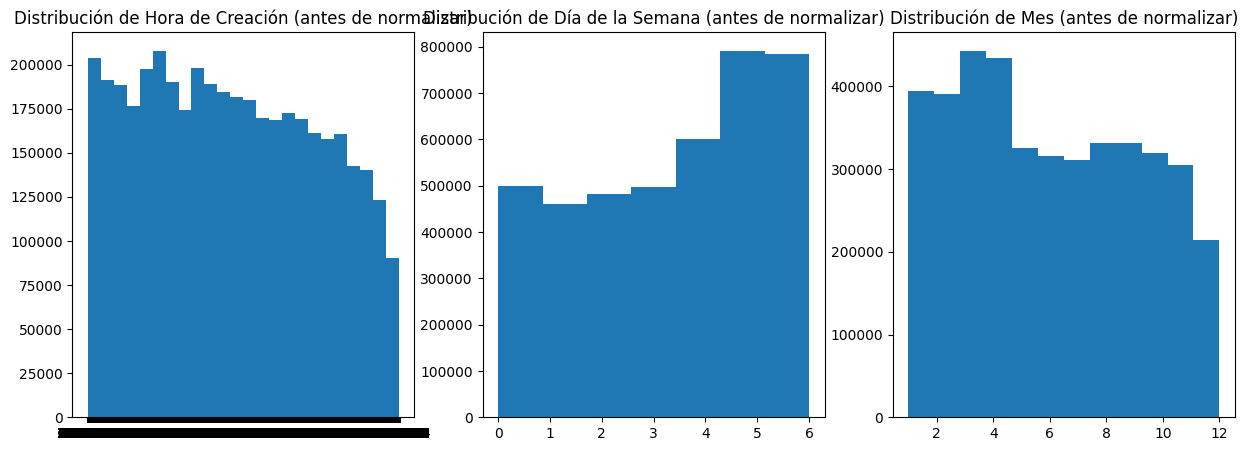

In [ ]:
# import matplotlib.pyplot as plt

# # Verificar la distribución antes de la normalización
# plt.figure(figsize=(15, 5))
# plt.subplot(1, 3, 1)
# plt.hist(df_llamadas['hora_creacion'], bins=24)
# plt.title('Distribución de Hora de Creación (antes de normalizar)')

# plt.subplot(1, 3, 2)
# plt.hist(df_llamadas['dia_semana'], bins=7)
# plt.title('Distribución de Día de la Semana (antes de normalizar)')

# plt.subplot(1, 3, 3)
# plt.hist(df_llamadas['mes'], bins=12)
# plt.title('Distribución de Mes (antes de normalizar)')

# plt.show()

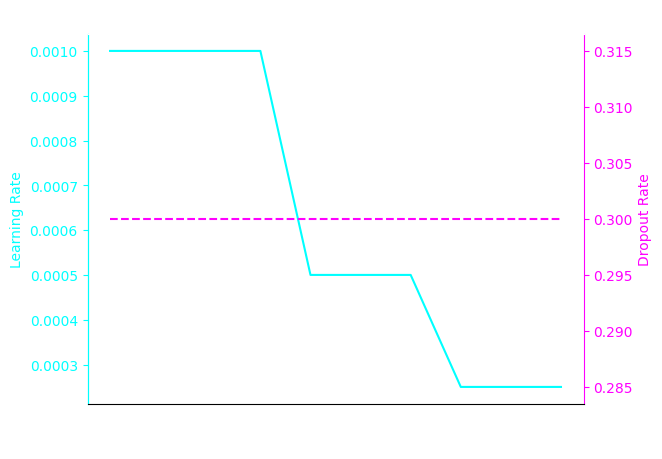

In [5]:
import matplotlib.pyplot as plt

# Supongamos que tenemos los datos de `learning rate` y `dropout` durante el entrenamiento en el historial del modelo `history`
# Extraer valores desde el historial de entrenamiento
learning_rates = history.history.get('lr', [0.001] * len(history.epoch))  # Ajustar si no se guarda lr en el historial
dropout_values = [0.3] * len(history.epoch)  # En este caso, la tasa de dropout se mantiene constante

# Crear una figura para graficar los valores de learning rate y dropout a través de las épocas
fig, ax1 = plt.subplots()

# Graficar el learning rate
ax1.set_xlabel('Época', color='white')
ax1.set_ylabel('Learning Rate', color='cyan')
ax1.plot(range(1, len(learning_rates) + 1), learning_rates, color='cyan', label='Learning Rate')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.spines['bottom'].set_color('white')
ax1.spines['left'].set_color('cyan')
ax1.spines['top'].set_color('white')
ax1.spines['right'].set_color('white')
ax1.tick_params(axis='x', colors='white')
ax1.tick_params(axis='y', colors='cyan')

# Crear un segundo eje Y para graficar el valor de dropout
ax2 = ax1.twinx()
ax2.set_ylabel('Dropout Rate', color='magenta')
ax2.plot(range(1, len(dropout_values) + 1), dropout_values, color='magenta', linestyle='--', label='Dropout Rate')
ax2.tick_params(axis='y', labelcolor='magenta')
ax2.spines['left'].set_color('cyan')
ax2.spines['top'].set_color('white')
ax2.spines['right'].set_color('magenta')
ax2.tick_params(axis='y', colors='magenta')

plt.title('Learning Rate y Dropout a través de las Épocas', color='white')
plt.savefig('learning_rate_dropout.png', transparent=True)
plt.show()